# Pre-trained models and transfer learning

Training CNNs can take a lot of time, and a lot of data is required for that task. However, much of the time is spent to learn the best low-level filters that a network is using to extract patterns from images. A natural question arises - can we use a neural network trained on one dataset and adapt it to classifying different images without full training process?

This approach is called **transfer learning**, because we transfer some knowledge from one neural network model to another. In transfer learning, we typically start with a pre-trained model, which has been trained on some large image dataset, such as **ImageNet**. Those models can already do a good job extracting different features from generic images, and in many cases just building a classifier on top of those extracted features can yield a good result.

In [20]:
  
# Script file to hide implementation details for PyTorch computer vision module

import builtins
import torch
import torch.nn as nn
from torch.utils import data
import torchvision
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import glob
import os
import zipfile 

default_device = 'cuda' if torch.cuda.is_available() else 'cpu'

def load_mnist(batch_size=64):
    builtins.data_train = torchvision.datasets.MNIST('./data',
        download=True,train=True,transform=ToTensor())
    builtins.data_test = torchvision.datasets.MNIST('./data',
        download=True,train=False,transform=ToTensor())
    builtins.train_loader = torch.utils.data.DataLoader(data_train,batch_size=batch_size)
    builtins.test_loader = torch.utils.data.DataLoader(data_test,batch_size=batch_size)
    
def train_epoch(net,dataloader,lr=0.01,optimizer=None,loss_fn = nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    net.train()
    total_loss,acc,count = 0,0,0
    for features,labels in dataloader:
        optimizer.zero_grad()
        lbls = labels.to(default_device)
        out = net(features.to(default_device))
        loss = loss_fn(out,lbls) #cross_entropy(out,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        _,predicted = torch.max(out,1)
        acc+=(predicted==lbls).sum()
        count+=len(labels)
    return total_loss.item()/count, acc.item()/count

def validate(net, dataloader,loss_fn=nn.NLLLoss()):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            lbls = labels.to(default_device)
            out = net(features.to(default_device))
            loss += loss_fn(out,lbls) 
            pred = torch.max(out,1)[1]
            acc += (pred==lbls).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

def train(net,train_loader,test_loader,optimizer=None,lr=0.01,epochs=10,loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        tl,ta = train_epoch(net,train_loader,optimizer=optimizer,lr=lr,loss_fn=loss_fn)
        vl,va = validate(net,test_loader,loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

def train_long(net,train_loader,test_loader,epochs=5,lr=0.01,optimizer=None,loss_fn = nn.NLLLoss(),print_freq=10):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    for epoch in range(epochs):
        net.train()
        total_loss,acc,count = 0,0,0
        for i, (features,labels) in enumerate(train_loader):
            lbls = labels.to(default_device)
            optimizer.zero_grad()
            out = net(features.to(default_device))
            loss = loss_fn(out,lbls)
            loss.backward()
            optimizer.step()
            total_loss+=loss
            _,predicted = torch.max(out,1)
            acc+=(predicted==lbls).sum()
            count+=len(labels)
            if i%print_freq==0:
                print("Epoch {}, minibatch {}: train acc = {}, train loss = {}".format(epoch,i,acc.item()/count,total_loss.item()/count))
        vl,va = validate(net,test_loader,loss_fn)
        print("Epoch {} done, validation acc = {}, validation loss = {}".format(epoch,va,vl))


def plot_results(hist):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(hist['train_acc'], label='Training acc')
    plt.plot(hist['val_acc'], label='Validation acc')
    plt.legend()
    plt.subplot(122)
    plt.plot(hist['train_loss'], label='Training loss')
    plt.plot(hist['val_loss'], label='Validation loss')
    plt.legend()

def plot_convolution(t,title=''):
    with torch.no_grad():
        c = nn.Conv2d(kernel_size=(3,3),out_channels=1,in_channels=1)
        c.weight.copy_(t)
        fig, ax = plt.subplots(2,6,figsize=(8,3))
        fig.suptitle(title,fontsize=16)
        for i in range(5):
            im = data_train[i][0]
            ax[0][i].imshow(im[0])
            ax[1][i].imshow(c(im.unsqueeze(0))[0][0])
            ax[0][i].axis('off')
            ax[1][i].axis('off')
        ax[0,5].imshow(t)
        ax[0,5].axis('off')
        ax[1,5].axis('off')
        #plt.tight_layout()
        plt.show()
        
def display_dataset(dataset, n=10,classes=None):
    fig,ax = plt.subplots(1,n,figsize=(15,3))
    mn = min([dataset[i][0].min() for i in range(n)])
    mx = max([dataset[i][0].max() for i in range(n)])
    for i in range(n):
        ax[i].imshow(np.transpose((dataset[i][0]-mn)/(mx-mn),(1,2,0)))
        ax[i].axis('off')
        if classes:
            ax[i].set_title(classes[dataset[i][1]])


def check_image(fn):
    try:
        im = Image.open(fn)
        im.verify()
        return True
    except:
        return False
    
def check_image_dir(path):
    for fn in glob.glob(path):
        if not check_image(fn):
            print("Corrupt image: {}".format(fn))
            os.remove(fn)


def common_transform():
    std_normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
    trans = torchvision.transforms.Compose([
            torchvision.transforms.Resize(256),
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.ToTensor(), 
            std_normalize])
    return trans

def load_cats_dogs_dataset():
    if not os.path.exists('data/PetImages'):
        with zipfile.ZipFile('data/kagglecatsanddogs_5340.zip', 'r') as zip_ref:
            zip_ref.extractall('data')

    check_image_dir('data/PetImages/Cat/*.jpg')
    check_image_dir('data/PetImages/Dog/*.jpg')

    dataset = torchvision.datasets.ImageFolder('data/PetImages',transform=common_transform())
    trainset, testset = torch.utils.data.random_split(dataset,[20000,len(dataset)-20000])
    trainloader = torch.utils.data.DataLoader(trainset,batch_size=32)
    testloader = torch.utils.data.DataLoader(trainset,batch_size=32)
    return dataset, trainloader, testloader

In [21]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import os



## Cats vs. Dogs Dataset

In this unit, we will solve a real-life problem of classifying images of cats and dogs. For this reason, we will use [Kaggle Cats vs. Dogs Dataset](https://www.kaggle.com/c/dogs-vs-cats), which can also be downloaded [from Microsoft](https://www.microsoft.com/en-us/download/details.aspx?id=54765).

Let's download this dataset and extract it into `data` directory (this process may take some time!):

In [25]:
import os
import zipfile

# if not os.path.exists('Notes/Pytorch Practice/Computer Vision with Pytorch/data/PetImages'):
#     with zipfile.ZipFile('data/dogs-vs-cats.zip', 'r') as zip_ref:
#         zip_ref.extractall('data/PetImages')



In [26]:
# if not os.path.exists('Notes/Pytorch Practice/Computer Vision with Pytorch/data/PetImages'):
#     with zipfile.ZipFile('data/PetImages/test1.zip', 'r') as zip_ref:
#         zip_ref.extractall('data/PetImages')
        
# if not os.path.exists('Notes/Pytorch Practice/Computer Vision with Pytorch/data/PetImages'):
#     with zipfile.ZipFile('data/PetImages/train.zip', 'r') as zip_ref:
#         zip_ref.extractall('data/PetImages')

In [34]:
check_image_dir('data/PetImages/test1/*.jpg')
check_image_dir('data/PetImages/train/*.jpg')

Next, let's load the images into PyTorch dataset, converting them to tensors and doing some normalization. We define image transformation pipeline by composing several primitive transformations using `Compose`:
* `Resize` resizes our image to 256x256 dimensions
* `CenterCrop` gets the central part of the image with size 224x224. Pre-trained VGG network has been trained on 224x224 images, thus we need to bring our dataset to this size.
* `ToTensor` normalizes pixel intensities to be in 0..1 range, and convert images to PyTorch tensors
* `std_normalize` transform is additional normalization step specific for VGG network. When training a VGG network, original images from ImageNet were transformed by subtracting dataset mean intensity by color and dividing by standard deviation (also by color). Thus, we need to apply the same transformation to our dataset, so that all images are processed correctly. 

There are a few reason why we resized images to size 256, and then cropped to 224 pixels:
* We wanted to demonstrate more possible transformations.
* Pets are usually somewhere in the central part of the image, so we can improve classification by focusing more on the central part
* Since some of the images are not square, we end up having padded parts of the image that do not contain any useful picture data, and cropping the image a bit reduces the padded part.

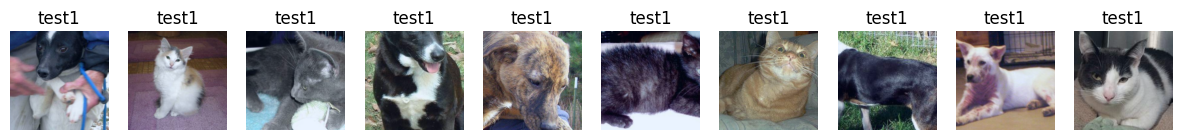

In [53]:
std_normalize=transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])

trans=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    std_normalize])

dataset = torchvision.datasets.ImageFolder('data/PetImages',transform=trans)
trainset, testset = torch.utils.data.random_split(dataset,[20000,len(dataset)-20000])

display_dataset(dataset,classes=dataset.classes,n=10)



## Pre-trained models

There are many different pre-trained models available inside `torchvision` module, and even more models can be found on the Internet. Let's see how simplest VGG-16 model can be loaded and used.  First, we'll download the weights for the VGG-16 model that we stored in a local repository.

In [56]:
file_path='models/vgg16-397923af.pth'

vgg=torchvision.models.vgg16(pretrained=True)
vgg.load_state_dict(torch.load(file_path))
vgg.eval()



c:\Users\alifa\OneDrive\Documents\Work\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alifa\OneDrive\Documents\Work\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\alifa/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [00:57<00:00, 9.69MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [60]:
sample_image=dataset[0][0].unsqueeze(0)
res=vgg(sample_image)
print(res[0].argmax())

tensor(227)


In [64]:
import json,requests

class_map = json.loads(requests.get("https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/imagenet_class_index.json").text)
class_map = { int(k) : v for k,v in class_map.items() }

class_map[res[0].argmax().item()]

['n02105412', 'kelpie']

In [65]:
summary(vgg,input_size=(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

In addition to the layer we already know, there is also another layer type called **Dropout**. These layers act as **regularization** technique. Regularization makes slight modifications to the learning algorithm so the model generalizes better. During training, dropout layers discard some proportion (around 30%) of the neurons in the previous layer, and training happens without them. This helps to get the optimization process out of local minima, and to distribute decisive power between different neural paths, which improves overall stability of the network.

## GPU computations

Deep neural networks, such as VGG-16 and other more modern architectures require quite a lot of computational power to run. It makes sense to use GPU acceleration, if it is available. In order to do so, we need to explicitly move all tensors involved in the computation to GPU.

The way it is normally done is to check the availability of GPU in the code, and define `device` variable that points to the computational device - either GPU or CPU.


In [66]:
device='cuda' if torch.cuda.is_available() else 'cpu'

print('Doing inference on device: {}'.format(device))

vgg.to(device)
sample_image=sample_image.to(device)

vgg(sample_image).argmax()

Doing inference on device: cuda


tensor(227, device='cuda:0')


## Extracting VGG features

If we want to use VGG-16 to extract features from our images, we need the model without final classification layers. In fact, this "feature extractor" can be obtained using `vgg.features` method:

torch.Size([1, 512, 7, 7])


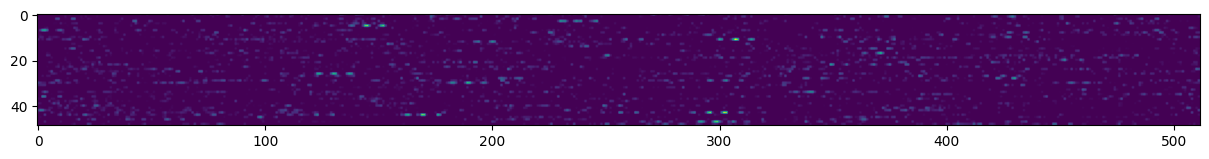

In [68]:
res = vgg.features(sample_image).cpu()
plt.figure(figsize=(15,15))
plt.imshow(res.detach().view(-1,512))
print(res.size())

The dimension of feature tensor is 512x7x7, but in order to visualize it we had to reshape it to 2D form.

Now let's try to see if those features can be used to classify images. Let's manually take some portion of images (800 in our case), and pre-compute their feature vectors. We will store the result in one big tensor called `feature_tensor`, and also labels into `label_tensor`:

In [70]:
bs =8
dl=torch.utils.data.DataLoader(dataset,batch_size=bs,shuffle=True)
num=bs*100
features=torch.zeros(num,512*7*7).to(device)
label=torch.zeros(num).to(device)
i=0

for x,l in dl:
    with torch.no_grad():
        f=vgg.features(x.to(device))
        features[i:i+bs]=f.view(bs,-1)
        label[i:i+bs]= l
        i+=bs
        print('.',end='')
        if i>=num:
            break
        

....................................................................................................

Now we can define `vgg_dataset` that takes data from this tensor, split it into training and test sets using `random_split` function, and train a small one-layer dense classifier network on top of extracted features:

In [71]:
vgg_dataset=torch.utils.data.TensorDataset(features,label.to(torch.long))
train_ds,test_ds=torch.utils.data.random_split(vgg_dataset,[700,100])

train_loader=torch.utils.data.DataLoader(train_ds,batch_size=32)
test_loader=torch.utils.data.DataLoader(test_ds,batch_size=32)

model=nn.Sequential(
    nn.Linear(512*7*7,2),
    nn.LogSoftmax(dim=1)
).to(device)

history=train(model,train_loader,test_loader)


Epoch  0, Train acc=0.581, Val acc=0.400, Train loss=0.458, Val loss=0.751
Epoch  1, Train acc=0.779, Val acc=0.480, Train loss=0.224, Val loss=1.029
Epoch  2, Train acc=0.844, Val acc=0.610, Train loss=0.181, Val loss=1.909
Epoch  3, Train acc=0.939, Val acc=0.400, Train loss=0.044, Val loss=1.320
Epoch  4, Train acc=0.983, Val acc=0.500, Train loss=0.008, Val loss=1.559
Epoch  5, Train acc=0.987, Val acc=0.580, Train loss=0.005, Val loss=1.396
Epoch  6, Train acc=0.983, Val acc=0.590, Train loss=0.008, Val loss=1.805
Epoch  7, Train acc=0.981, Val acc=0.420, Train loss=0.008, Val loss=1.515
Epoch  8, Train acc=0.984, Val acc=0.360, Train loss=0.010, Val loss=1.482
Epoch  9, Train acc=0.990, Val acc=0.400, Train loss=0.005, Val loss=1.544


The result is great, we can distinguish between a cat and a dog with almost 98% probability! However, we have only tested this approach on a small subset of all images, because manual feature extraction seems to take a lot of time.

## Transfer learning using one VGG network

We can also avoid manually pre-computing the features by using the original VGG-16 network as a whole during training. Let's look at the VGG-16 object structure:

In [72]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

You can see that the network contains:
* feature extractor (`features`), comprised of a number of convolutional and pooling layers
* average pooling layer (`avgpool`)
* final `classifier`, consisting of several dense layers, which turns 25088 input features into 1000 classes (which is the number of classes in ImageNet)

To train the end-to-end model that will classify our dataset, we need to:
* **replace the final classifier** with the one that will produce required number of classes. In our case, we can use one `Linear` layer with 25088 inputs and 2 output neurons.
* **freeze weights of convolutional feature extractor**, so that they are not trained. It is recommended to initially do this freezing, because otherwise untrained classifier layer can destroy the original pre-trained weights of convolutional extractor. Freezing weights can be accomplished by setting `requires_grad` property of all parameters to `False`

In [73]:
vgg.classifier=nn.Linear(25088,2).to(device)

for x in vgg.features.parameters():
    x.requires_grad=False
    
summary(vgg,input_size=(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 2]                    --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         (1,792)
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         (36,928)
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        (73,856)
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        (147,584)
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]    

As you can see from the summary, this model contain around 15 million total parameters, but only 50k of them are trainable - those are the weights of classification layer. That is good, because we are able to fine-tune smaller number of parameters with smaller number of examples.

Now let's train the model using our original dataset. This process will take a long time, so we will use the `train_long` function that will print some intermediate results without waiting for the end of epoch. It is highly recommended to run this training on GPU-enabled compute!

> **Note:** If you are interested in the implementation of the `train_long` function, refer to the `pytorchcv.py` file.

In [74]:
def train_long(model,train_loader,test_loader,epochs=10,lr=1e-3,optimizer=None,loss_fn=nn.NLLLoss(),print_freq=10):
    optimizer=optimizer or torch.optim.Adam(model.parameters(),lr=lr)
    
    for epoch in range(epochs):
        model.train()
        total_loss,acc,count=0,0,0
        
        for i,(features,labels) in enumerate(train_loader):
            lbls=labels.to(device)
            optimizer.zero_grad()
            out=model(features.to(device))
            loss=loss_fn(out,lbls)
            loss.backward()
            optimizer.step()
            total_loss+=loss
            _,predicted=torch.max(out,1)
            acc+=(predicted==lbls).sum()
            count+=len(labels)
            if i%print_freq==0:
                print("Epoch {}, minibatch {}: train acc = {}, train loss = {}".format(epoch+1,i,acc.item()/count,total_loss.item()/count))
                
        vl,va=validate(model,test_loader,loss_fn)
        print("Epoch {} done, validation acc = {}, validation loss = {}".format(epoch+1,va,vl))
        
        


In [75]:
train_set,test_set=torch.utils.data.random_split(dataset,[20000,len(dataset)-20000])
train_loader=torch.utils.data.DataLoader(train_set,batch_size=16)
test_loader=torch.utils.data.DataLoader(test_set,batch_size=16)

train_long(vgg,train_loader,test_loader,loss_fn=nn.CrossEntropyLoss(),epochs=1,lr=1e-3,print_freq=90)

Epoch 1, minibatch 0: train acc = 0.75, train loss = 0.03460295498371124
Epoch 1, minibatch 90: train acc = 0.5563186813186813, train loss = 0.1397545678274972
Epoch 1, minibatch 180: train acc = 0.5517955801104972, train loss = 0.157478174451965
Epoch 1, minibatch 270: train acc = 0.5571955719557196, train loss = 0.1740555991985701
Epoch 1, minibatch 360: train acc = 0.560595567867036, train loss = 0.17509326247957605
Epoch 1, minibatch 450: train acc = 0.5573725055432373, train loss = 0.17799632882331798
Epoch 1, minibatch 540: train acc = 0.5570702402957486, train loss = 0.18159576528834767
Epoch 1, minibatch 630: train acc = 0.5576465927099842, train loss = 0.18441190885855166
Epoch 1, minibatch 720: train acc = 0.555131761442441, train loss = 0.1907203028833651
Epoch 1, minibatch 810: train acc = 0.5571054254007398, train loss = 0.19488344768707613
Epoch 1, minibatch 900: train acc = 0.5541759156492786, train loss = 0.1991390012345224
Epoch 1, minibatch 990: train acc = 0.55619323

In [76]:
torch.save(vgg,'models/-dogs.pth')

## Fine-tuning transfer learning

In the previous section, we have trained the final classifier layer to classify images in our own dataset. However, we did not re-train the feature extractor, and our model relied on the features that the model has learned on ImageNet data. If your objects visually differ from ordinary ImageNet images, this combination of features might not work best. Thus it makes sense to start training convolutional layers as well.

To do that, we can unfreeze the convolutional filter parameters that we have previously frozen. 

> **Note:** It is important that you freeze parameters first and perform several epochs of training in order to stabilize weights in the classification layer. If you immediately start training end-to-end network with unfrozen parameters, large errors are likely to destroy the pre-trained weights in the convolutional layers.

In [79]:
for x in vgg.features.parameters():
    x.requires_grad=True

After unfreezing, we can do a few more epochs of training. You can also select lower learning rate, in order to minimize the impact on the pre-trained weights. However, even with low learning rate, you can expect the accuracy to drop in the beginning of the training, until finally reaching slightly higher level than in the case of fixed weights.

> **Note:** This training happens much slower, because we need to propagate gradients back through many layers of the network! You may want to watch the first few minibatches to see the tendency, and then stop the computation.

In [81]:
train_long(vgg,train_loader,test_loader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=1,print_freq=90,lr=1e-4)

Epoch 1, minibatch 0: train acc = 0.5625, train loss = 0.04257715493440628
Epoch 1, minibatch 90: train acc = 0.6593406593406593, train loss = 0.04346435410635812
Epoch 1, minibatch 180: train acc = 0.6508977900552486, train loss = 0.04234644589503167
Epoch 1, minibatch 270: train acc = 0.6501383763837638, train loss = 0.041912568011407046
Epoch 1, minibatch 360: train acc = 0.653393351800554, train loss = 0.04156791602475491
Epoch 1, minibatch 450: train acc = 0.6554878048780488, train loss = 0.04137805084431515
Epoch 1, minibatch 540: train acc = 0.6587338262476895, train loss = 0.04120139582099844
Epoch 1, minibatch 630: train acc = 0.660459587955626, train loss = 0.041021189863443754
Epoch 1, minibatch 720: train acc = 0.6597607489597781, train loss = 0.04097195174260874
Epoch 1, minibatch 810: train acc = 0.6609895191122072, train loss = 0.040866555473807416


KeyboardInterrupt: 

## Other computer vision models

VGG-16 is one of the simplest computer vision architectures. `torchvision` package provides many more pre-trained networks. The most frequently used ones among those are **ResNet** architectures, developed by Microsoft, and **Inception** by Google. For example, let's explore the architecture of the simplest ResNet-18 model (ResNet is a family of models with different depth, you can try experimenting with ResNet-151 if you want to see what a really deep model looks like):

In [82]:
resnet=torchvision.models.resnet18(pretrained=True)
print(resnet)


c:\Users\alifa\OneDrive\Documents\Work\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alifa\OneDrive\Documents\Work\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\alifa/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:03<00:00, 11.8MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [83]:
summary(resnet,input_size=(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

As you can see, the model contains the same building blocks: feature extractor and final classifier (`fc`). This allows us to use this model in exactly the same manner as we have been using VGG-16 for transfer learning. You can try experimenting with the code above, using different ResNet models as the base model, and see how accuracy changes.

## Batch Normalization

This network contains yet another type of layer: **Batch Normalization**. The idea of batch normalization is to bring values that flow through the neural network to right interval. Usually neural networks work best when all values are in the range of [-1,1] or [0,1], and that is the reason that we scale/normalize our input data accordingly. However, during training of a deep network, it can happen that values get significantly out of this range, which makes training problematic. Batch normalization layer computes average and standard deviation for all values of the current minibatch, and uses them to normalize the signal before passing it through a neural network layer. This significantly improves the stability of deep networks.


## Takeaway

Using transfer learning, we were able to quickly put together a classifier for our custom object classification task, and achieve high accuracy. However, this example was not completely fair, because original VGG-16 network was pre-trained to recognize cats and dogs, and thus we were just reusing most of the patterns that were already present in the network. You can expect lower accuracy on more exotic domain-specific objects, such as details on production line in a plant, or different tree leaves.

You can see that more complex tasks that we are solving now require higher computational power, and cannot be easily solved on the CPU. In the next unit, we will try to use more lightweight implementation to train the same model using lower compute resources, which results in just slightly lower accuracy. 